# Kernel Density Estimation

* Density Estimator:
    * Density estimator is an algorithm that takes a D-dimensional dataset and produces an estimate of the D-dimensional probability distribution that data is drawn from.
    * The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions.

* Kernel Density Estimation (KDE):
    * In some senses, is an algorithm that takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component per point, resulting in an essentially nonparametric estimator of density.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# A. KDE : Histograms

* Histograms are simple density estimator for 1-D data.
    * Divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

* One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features:
    * The number of data points can change the choice of how to draw the bins and can lead to an entirely different interpretation of the data.

* If we imagine histograms as stack of blocks, the height of the block stack often reflects not the actual density of points nearby, but coincidences of how the bins align with the data points.
    * This misalignment between points and their blocks is a potential cause of the poor histogram.

* Instead of stacking the blocks aligned with the bins, stack the blocks aligned with the points they represent.
    * If we do this, the blocks won’t be aligned, but we can add their contributions at each location along the x-axis to find the result.

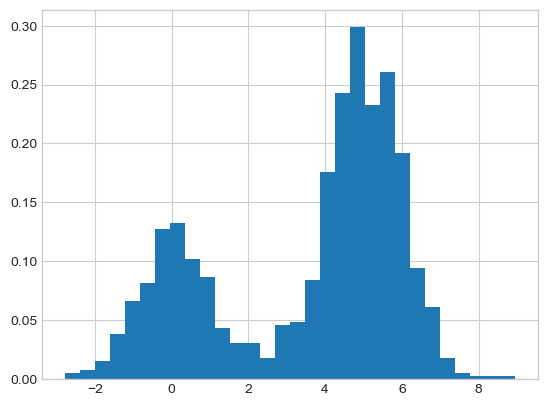

In [4]:
def make_data(N, f=0.3, rseed=1):
    """Create Data that is drawn from 2 normal distributions"""
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

# `density=True`: Height of the bins does not reflect counts, but instead reflects probability density
hist = plt.hist(x, bins=30, density=True)

In [8]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

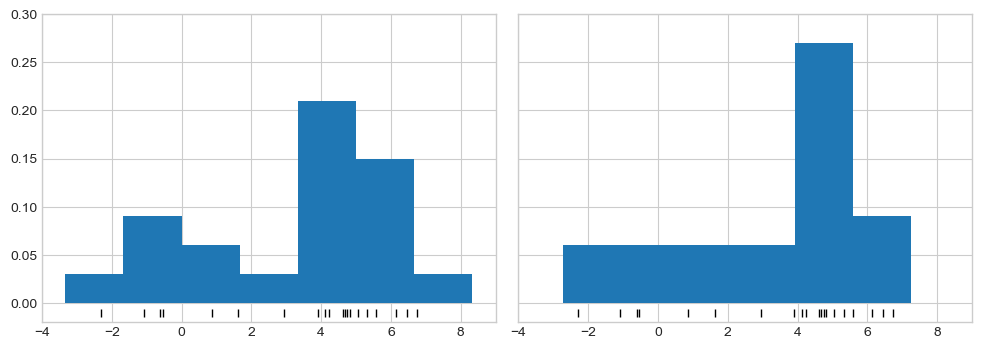

In [10]:
# For a data of 20 points can lead to an entirely different interpretation.
x = make_data(20)
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                        sharex=True, sharey=True,
                        subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})

fig.subplots_adjust(wspace=0.05)

for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

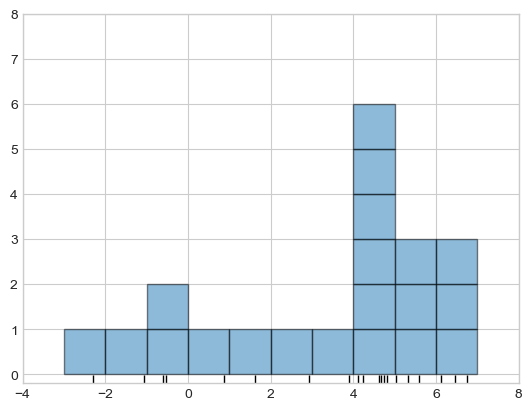

In [11]:
# Histograms as stack of blocks
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, ec='black', alpha=0.5))

ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8);


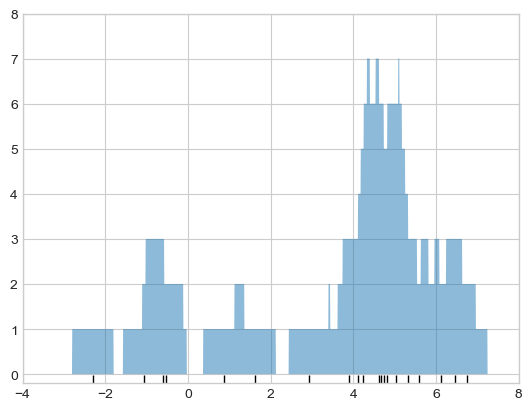

In [12]:
# stack the blocks aligned with the points they represent
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

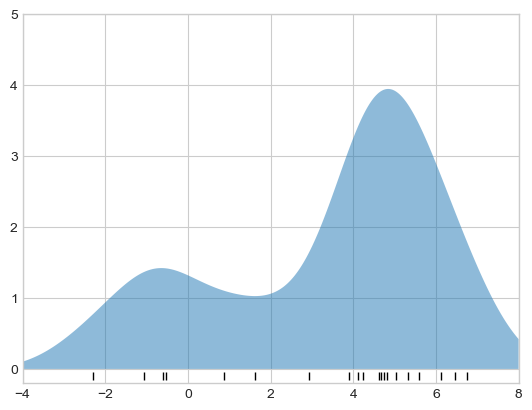

In [13]:
# use a standard normal curve at each point instead of a block
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5]);

# B. KDE in Practice

* Free Parameters of kernel density:
    * Kernel - Specifies the shape of the distribution place at each point
    * Kernel Bandwidth - Controls the size of the kernel at each point.
    * In practice, there are many kernels you might use for kernel density estimation: in particular, the Scikit-Learn KDE implementation supports six kernels.

* `sklearn.neighbors.KernelDensity`:
    * handles KDE in multiple dimensions w/ one of six kernels and one of a couple dozen instance metrics.
    * Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the `atol` (absolute tolerance) and `rtol` (relative tolerance) parameters.
    * The kernel bandwidth can be determined using Scikit-Learn’s standard cross-validation tools.

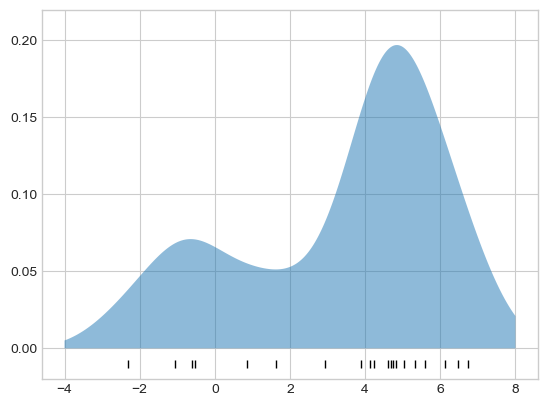

In [14]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22);